Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в доработке!

Проектная работа

# Временные ряды - Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

    Загрузить данные и выполнить их ресемплирование по одному часу.
    Проанализировать данные.
    Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
    Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).


## 1. Загрузка данных и ресемплирование

In [48]:
# импорт библиотек
import pandas as pd#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [43]:
!pip install optuna
import optuna  

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e2a4dfa41b802ddc201b0ddb35754d1df44a583e92210e85af161295ad5693e9
  Stored in directory: c:\users\dande\appdata\local\pip\cache\wheels\0c\09\9e\49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [3]:
# загрузка датасета
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head()
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [5]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


<AxesSubplot:xlabel='datetime'>

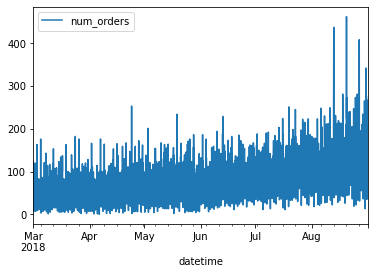

In [6]:
data = df.resample('1H').sum()
data.plot()

In [7]:
def count_missing(df): # функция для подсчета пропусков в столбцах
    nan = df.isnull().sum().sort_values(ascending=False) 
    missing_val = nan[nan > 0]
    return missing_val
print(count_missing(data))

Series([], dtype: int64)


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

## 2. Анализ данных

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

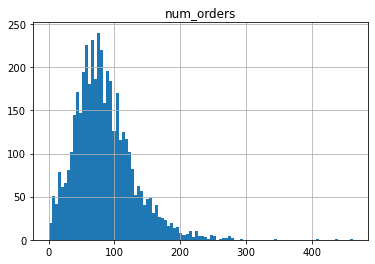

In [8]:
print(data.describe())

data.hist(bins=100)

In [9]:
# поиск трендов

decomposed = seasonal_decompose(data) 

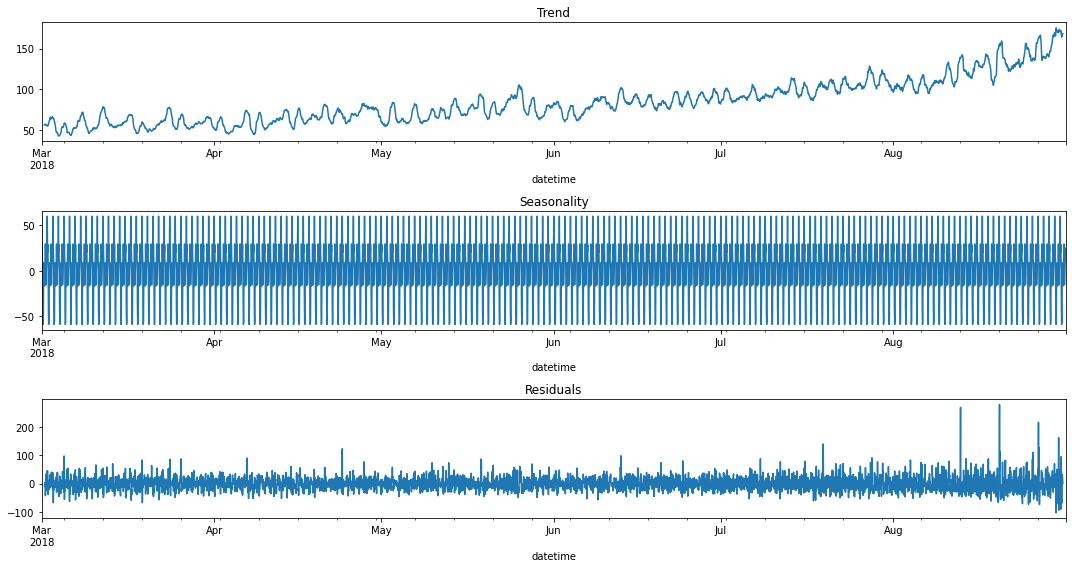

In [10]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (get current axis = получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Если верить графикам, количество вызовов такси со временем растет. Учитывая, что датасет сгруппирован по часам, скорее всего интересное найдется при анализе суточных или недельных колебаний.

<AxesSubplot:xlabel='datetime'>

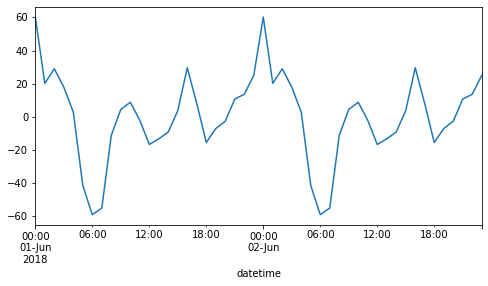

In [11]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(figsize=(8, 4)) # суточные колебания за 1 июня

Пик около полуночи, спад около 6 утра

<AxesSubplot:xlabel='datetime'>

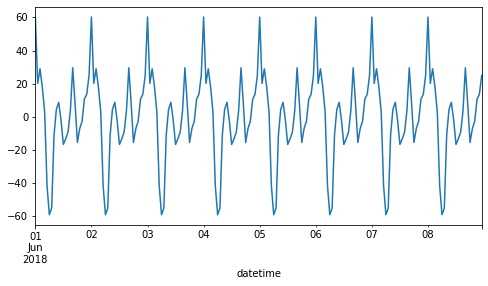

In [12]:
decomposed.seasonal['2018-06-01':'2018-06-08'].plot(figsize=(8, 4)) # колебания за 1 неделю

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале.
</div>

## 3. Обучение моделей

### Создание признаков

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = data.index.month  # календарные признаки
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['hour'] = data.index.hour
    
    for i in range(max_lag):   # "отстающие" значения
        new_data['lag_{}'.format(i+1)] = data['num_orders'].shift(i+1)
        
    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() # скользящее среднее
    return new_data
    

new_data = make_features(data, 6, 8)
display(new_data.head())

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> готово, появилась переменная new_data
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

In [14]:
new_data = new_data.dropna() # избавимся от пропусков
new_data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,52.750
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,41.500
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,39.500
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,38.625
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,42.375


### Разделение данных на обучающие и тренировочные

In [15]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1) #обучающая и тестовая выборки

print(train.index.min(), train.index.max()) # нужно убедиться, что они идут по временному ряду друг за другом
print(test.index.min(), test.index.max())

2018-03-01 08:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [16]:
# выделение целевого признака
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

### Обучение моделей

In [17]:
#функция метрики для кросс-валидации
def rmse(true, pred):
    return mean_squared_error(true, pred) ** 0.5
rmse_score = make_scorer(rmse)

In [18]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
def cross_validation(est):
    all_scores = cross_val_score(scoring=rmse_score,estimator=est, X=features_train, y=target_train, cv=tscv)
    return all_scores.mean()

In [19]:
# линейная регрессия
model_1 = LinearRegression() # инициализация модели
model_1.fit(features_train, target_train) # обучение модели на тренировочной выборке
predictions = model_1.predict(features_train) # предсказания модели на тренировочной выборке
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 30.426558356128783


In [20]:
# линейная регрессия
print('средняя точность на валидационных выборках:',cross_validation(model_1))

средняя точность на валидационных выборках: 31.51456521840297


In [21]:
#DecisionTreeRegressor
model_2 = DecisionTreeRegressor()
model_2.fit(features_train, target_train) # обучение модели на тренировочной выборке
predictions = model_2.predict(features_train) # предсказания модели на тренировочной выборке
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)
print('средняя точность на валидационных выборках:',cross_validation(model_2))

RMSE = 0.0
средняя точность на валидационных выборках: 32.29754479548643


In [37]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#max_depth
model_3_1 = None
best_depth = 0
best_result = 40
for depth in range(3, 8, 1):
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_1 = model
        best_result = score
        best_depth_1 = depth
        
print('best_result = ', best_result, 'depth = ', best_depth_1)

Wall time: 0 ns
best_result =  26.83463048606572 depth =  7


In [39]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
for est in range(15, 150, 30):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.754663355659705 est =  105


In [24]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
best_est = 0
for est in range(80, 125, 5):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.13341143392638 est =  105


In [40]:
%time
#RandomForestRegressor
#подбор гиперпараметров
#n_estimators
for est in range(100, 110, 1):
    model = RandomForestRegressor(n_estimators=est, max_depth=best_depth_1, random_state=12345)
    score = cross_validation(model)
    if score < best_result:
        model_3_2 = model
        best_result = score
        best_est_1 = est
print('best_result = ', best_result, 'est = ', best_est_1)

Wall time: 0 ns
best_result =  26.750140364523315 est =  108


In [38]:
#RandomForestRegressor - обучение
model_3_2.fit(features_train, target_train)

RandomForestRegressor(max_depth=8, n_estimators=108, random_state=12345)

In [27]:
#cat boost
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=200)
model_cat.fit(features_train, target_train, verbose=30)
predictions = model_cat.predict(features_train)
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)
cross_validation(model_cat)

Learning rate set to 0.188365
0:	learn: 35.7087667	total: 146ms	remaining: 29s
30:	learn: 22.2411001	total: 306ms	remaining: 1.67s
60:	learn: 19.9566492	total: 433ms	remaining: 986ms
90:	learn: 18.3365115	total: 573ms	remaining: 686ms
120:	learn: 17.0001649	total: 698ms	remaining: 456ms
150:	learn: 15.9224589	total: 836ms	remaining: 271ms
180:	learn: 15.1079376	total: 994ms	remaining: 104ms
199:	learn: 14.6486200	total: 1.13s	remaining: 0us
RMSE = 14.648619953549844
Learning rate set to 0.141951
0:	learn: 27.6367688	total: 11.4ms	remaining: 2.27s
1:	learn: 25.9703103	total: 14.3ms	remaining: 1.42s
2:	learn: 24.5062353	total: 17.2ms	remaining: 1.13s
3:	learn: 23.2917056	total: 20.1ms	remaining: 985ms
4:	learn: 22.2848396	total: 23ms	remaining: 898ms
5:	learn: 21.4744936	total: 25.9ms	remaining: 837ms
6:	learn: 20.7851995	total: 28.6ms	remaining: 789ms
7:	learn: 20.1706436	total: 31.5ms	remaining: 756ms
8:	learn: 19.5044485	total: 35.2ms	remaining: 747ms
9:	learn: 19.1498699	total: 38.1m

192:	learn: 6.6230452	total: 620ms	remaining: 22.5ms
193:	learn: 6.5817841	total: 624ms	remaining: 19.3ms
194:	learn: 6.5399169	total: 629ms	remaining: 16.1ms
195:	learn: 6.5140471	total: 633ms	remaining: 12.9ms
196:	learn: 6.4677525	total: 637ms	remaining: 9.71ms
197:	learn: 6.4351114	total: 644ms	remaining: 6.5ms
198:	learn: 6.4291419	total: 648ms	remaining: 3.26ms
199:	learn: 6.4193585	total: 651ms	remaining: 0us
Learning rate set to 0.158361
0:	learn: 28.4912927	total: 4.92ms	remaining: 978ms
1:	learn: 26.9032757	total: 8.59ms	remaining: 850ms
2:	learn: 25.6703435	total: 12.5ms	remaining: 821ms
3:	learn: 24.5771182	total: 17.3ms	remaining: 850ms
4:	learn: 23.4801448	total: 21.4ms	remaining: 834ms
5:	learn: 22.7604375	total: 25.1ms	remaining: 811ms
6:	learn: 22.2212589	total: 29.5ms	remaining: 814ms
7:	learn: 21.6538503	total: 34ms	remaining: 817ms
8:	learn: 21.3355885	total: 37.1ms	remaining: 787ms
9:	learn: 20.9209749	total: 40.2ms	remaining: 763ms
10:	learn: 20.6289916	total: 43.

170:	learn: 9.6443652	total: 592ms	remaining: 100ms
171:	learn: 9.6117498	total: 597ms	remaining: 97.2ms
172:	learn: 9.5778526	total: 602ms	remaining: 94ms
173:	learn: 9.5350140	total: 609ms	remaining: 90.9ms
174:	learn: 9.4991520	total: 612ms	remaining: 87.5ms
175:	learn: 9.4489920	total: 615ms	remaining: 83.9ms
176:	learn: 9.4011568	total: 618ms	remaining: 80.4ms
177:	learn: 9.3862466	total: 621ms	remaining: 76.8ms
178:	learn: 9.3698002	total: 624ms	remaining: 73.2ms
179:	learn: 9.3682543	total: 627ms	remaining: 69.7ms
180:	learn: 9.3442786	total: 630ms	remaining: 66.2ms
181:	learn: 9.3260378	total: 634ms	remaining: 62.7ms
182:	learn: 9.3249648	total: 637ms	remaining: 59.2ms
183:	learn: 9.3012632	total: 640ms	remaining: 55.7ms
184:	learn: 9.2565706	total: 643ms	remaining: 52.2ms
185:	learn: 9.2244519	total: 646ms	remaining: 48.6ms
186:	learn: 9.1759085	total: 649ms	remaining: 45.1ms
187:	learn: 9.1569835	total: 653ms	remaining: 41.7ms
188:	learn: 9.1226982	total: 657ms	remaining: 38.

144:	learn: 12.3260403	total: 545ms	remaining: 207ms
145:	learn: 12.3066798	total: 550ms	remaining: 203ms
146:	learn: 12.2916137	total: 556ms	remaining: 201ms
147:	learn: 12.2674011	total: 562ms	remaining: 198ms
148:	learn: 12.2472919	total: 566ms	remaining: 194ms
149:	learn: 12.1823494	total: 570ms	remaining: 190ms
150:	learn: 12.1161741	total: 573ms	remaining: 186ms
151:	learn: 12.0745907	total: 577ms	remaining: 182ms
152:	learn: 12.0390461	total: 580ms	remaining: 178ms
153:	learn: 11.9896807	total: 583ms	remaining: 174ms
154:	learn: 11.9459798	total: 586ms	remaining: 170ms
155:	learn: 11.9134133	total: 590ms	remaining: 166ms
156:	learn: 11.8987098	total: 593ms	remaining: 162ms
157:	learn: 11.8720781	total: 597ms	remaining: 159ms
158:	learn: 11.8374421	total: 600ms	remaining: 155ms
159:	learn: 11.7769570	total: 604ms	remaining: 151ms
160:	learn: 11.7365869	total: 608ms	remaining: 147ms
161:	learn: 11.7139424	total: 612ms	remaining: 143ms
162:	learn: 11.6706731	total: 615ms	remaining:

132:	learn: 14.0901358	total: 590ms	remaining: 297ms
133:	learn: 14.0628856	total: 596ms	remaining: 294ms
134:	learn: 14.0035369	total: 604ms	remaining: 291ms
135:	learn: 13.9356981	total: 609ms	remaining: 287ms
136:	learn: 13.8882017	total: 614ms	remaining: 282ms
137:	learn: 13.8364068	total: 619ms	remaining: 278ms
138:	learn: 13.7946452	total: 623ms	remaining: 273ms
139:	learn: 13.7492054	total: 627ms	remaining: 269ms
140:	learn: 13.7057401	total: 632ms	remaining: 264ms
141:	learn: 13.6537021	total: 636ms	remaining: 260ms
142:	learn: 13.6305322	total: 640ms	remaining: 255ms
143:	learn: 13.5718196	total: 643ms	remaining: 250ms
144:	learn: 13.5286224	total: 648ms	remaining: 246ms
145:	learn: 13.4712732	total: 652ms	remaining: 241ms
146:	learn: 13.4402533	total: 655ms	remaining: 236ms
147:	learn: 13.4220986	total: 660ms	remaining: 232ms
148:	learn: 13.3962899	total: 664ms	remaining: 227ms
149:	learn: 13.3712817	total: 669ms	remaining: 223ms
150:	learn: 13.3164170	total: 673ms	remaining:

119:	learn: 15.4531069	total: 525ms	remaining: 350ms
120:	learn: 15.4318686	total: 532ms	remaining: 347ms
121:	learn: 15.3996131	total: 539ms	remaining: 344ms
122:	learn: 15.3644470	total: 543ms	remaining: 340ms
123:	learn: 15.3172254	total: 548ms	remaining: 336ms
124:	learn: 15.2763714	total: 552ms	remaining: 331ms
125:	learn: 15.2613134	total: 556ms	remaining: 326ms
126:	learn: 15.2015865	total: 560ms	remaining: 322ms
127:	learn: 15.1656560	total: 564ms	remaining: 317ms
128:	learn: 15.1450289	total: 568ms	remaining: 313ms
129:	learn: 15.1110036	total: 572ms	remaining: 308ms
130:	learn: 15.0800317	total: 576ms	remaining: 303ms
131:	learn: 15.0606214	total: 580ms	remaining: 299ms
132:	learn: 15.0261228	total: 584ms	remaining: 294ms
133:	learn: 14.9959373	total: 588ms	remaining: 290ms
134:	learn: 14.9929962	total: 593ms	remaining: 285ms
135:	learn: 14.9243460	total: 597ms	remaining: 281ms
136:	learn: 14.8853896	total: 601ms	remaining: 276ms
137:	learn: 14.8345483	total: 605ms	remaining:

25.284797817274683

In [28]:
cross_validation(model_cat)

Learning rate set to 0.141951
0:	learn: 27.6367688	total: 5.41ms	remaining: 1.08s
1:	learn: 25.9703103	total: 8.04ms	remaining: 796ms
2:	learn: 24.5062353	total: 10.7ms	remaining: 700ms
3:	learn: 23.2917056	total: 14ms	remaining: 686ms
4:	learn: 22.2848396	total: 17ms	remaining: 664ms
5:	learn: 21.4744936	total: 19.7ms	remaining: 637ms
6:	learn: 20.7851995	total: 22.3ms	remaining: 614ms
7:	learn: 20.1706436	total: 24.8ms	remaining: 596ms
8:	learn: 19.5044485	total: 27.9ms	remaining: 592ms
9:	learn: 19.1498699	total: 30.6ms	remaining: 581ms
10:	learn: 18.7209362	total: 34ms	remaining: 584ms
11:	learn: 18.3723699	total: 36.5ms	remaining: 571ms
12:	learn: 18.0941570	total: 39ms	remaining: 562ms
13:	learn: 17.9439858	total: 39.9ms	remaining: 530ms
14:	learn: 17.8047663	total: 42.7ms	remaining: 527ms
15:	learn: 17.6369615	total: 45.5ms	remaining: 523ms
16:	learn: 17.3927689	total: 52.4ms	remaining: 564ms
17:	learn: 17.2473478	total: 58ms	remaining: 586ms
18:	learn: 17.0851985	total: 64.3ms	

163:	learn: 7.6512726	total: 562ms	remaining: 123ms
164:	learn: 7.6189199	total: 565ms	remaining: 120ms
165:	learn: 7.5769941	total: 569ms	remaining: 117ms
166:	learn: 7.5230417	total: 574ms	remaining: 114ms
167:	learn: 7.4952716	total: 579ms	remaining: 110ms
168:	learn: 7.4334521	total: 582ms	remaining: 107ms
169:	learn: 7.3956490	total: 585ms	remaining: 103ms
170:	learn: 7.3531629	total: 587ms	remaining: 99.6ms
171:	learn: 7.3518516	total: 590ms	remaining: 96ms
172:	learn: 7.3047660	total: 593ms	remaining: 92.5ms
173:	learn: 7.2742413	total: 596ms	remaining: 89.1ms
174:	learn: 7.2544478	total: 599ms	remaining: 85.6ms
175:	learn: 7.2106469	total: 602ms	remaining: 82.1ms
176:	learn: 7.1664781	total: 605ms	remaining: 78.6ms
177:	learn: 7.1255424	total: 607ms	remaining: 75.1ms
178:	learn: 7.0385694	total: 610ms	remaining: 71.6ms
179:	learn: 7.0190940	total: 614ms	remaining: 68.2ms
180:	learn: 6.9855264	total: 618ms	remaining: 64.8ms
181:	learn: 6.9604929	total: 622ms	remaining: 61.5ms
18

121:	learn: 11.3653425	total: 443ms	remaining: 283ms
122:	learn: 11.3461217	total: 448ms	remaining: 280ms
123:	learn: 11.2957040	total: 453ms	remaining: 278ms
124:	learn: 11.2608563	total: 458ms	remaining: 275ms
125:	learn: 11.2318739	total: 462ms	remaining: 271ms
126:	learn: 11.1869821	total: 466ms	remaining: 268ms
127:	learn: 11.1217363	total: 469ms	remaining: 264ms
128:	learn: 11.0924259	total: 473ms	remaining: 260ms
129:	learn: 11.0498065	total: 476ms	remaining: 256ms
130:	learn: 10.9919463	total: 479ms	remaining: 252ms
131:	learn: 10.9671861	total: 482ms	remaining: 248ms
132:	learn: 10.9328237	total: 485ms	remaining: 244ms
133:	learn: 10.9308889	total: 489ms	remaining: 241ms
134:	learn: 10.8876467	total: 492ms	remaining: 237ms
135:	learn: 10.8415763	total: 494ms	remaining: 233ms
136:	learn: 10.8115497	total: 497ms	remaining: 229ms
137:	learn: 10.7662708	total: 500ms	remaining: 225ms
138:	learn: 10.7399592	total: 503ms	remaining: 221ms
139:	learn: 10.7382120	total: 506ms	remaining:

89:	learn: 14.6854010	total: 405ms	remaining: 495ms
90:	learn: 14.6560809	total: 411ms	remaining: 492ms
91:	learn: 14.6252772	total: 418ms	remaining: 490ms
92:	learn: 14.6231223	total: 421ms	remaining: 485ms
93:	learn: 14.5812734	total: 425ms	remaining: 479ms
94:	learn: 14.5004435	total: 428ms	remaining: 473ms
95:	learn: 14.4442816	total: 432ms	remaining: 468ms
96:	learn: 14.4188730	total: 435ms	remaining: 462ms
97:	learn: 14.3678990	total: 439ms	remaining: 457ms
98:	learn: 14.2978338	total: 443ms	remaining: 452ms
99:	learn: 14.2172694	total: 446ms	remaining: 446ms
100:	learn: 14.1513869	total: 450ms	remaining: 441ms
101:	learn: 14.0721030	total: 453ms	remaining: 435ms
102:	learn: 14.0701992	total: 457ms	remaining: 430ms
103:	learn: 14.0667669	total: 460ms	remaining: 425ms
104:	learn: 14.0627891	total: 463ms	remaining: 419ms
105:	learn: 14.0543463	total: 466ms	remaining: 413ms
106:	learn: 14.0000038	total: 470ms	remaining: 408ms
107:	learn: 13.9607511	total: 473ms	remaining: 403ms
108:

57:	learn: 17.5727278	total: 283ms	remaining: 694ms
58:	learn: 17.4678231	total: 290ms	remaining: 694ms
59:	learn: 17.4516562	total: 297ms	remaining: 694ms
60:	learn: 17.3433152	total: 305ms	remaining: 696ms
61:	learn: 17.2192012	total: 312ms	remaining: 694ms
62:	learn: 17.1744792	total: 318ms	remaining: 692ms
63:	learn: 17.1076037	total: 324ms	remaining: 688ms
64:	learn: 17.0762256	total: 328ms	remaining: 681ms
65:	learn: 17.0063732	total: 334ms	remaining: 678ms
66:	learn: 16.9532612	total: 339ms	remaining: 672ms
67:	learn: 16.8877492	total: 344ms	remaining: 668ms
68:	learn: 16.8734381	total: 351ms	remaining: 666ms
69:	learn: 16.7967097	total: 360ms	remaining: 669ms
70:	learn: 16.7097988	total: 368ms	remaining: 668ms
71:	learn: 16.6767911	total: 376ms	remaining: 669ms
72:	learn: 16.6297435	total: 384ms	remaining: 668ms
73:	learn: 16.5813303	total: 397ms	remaining: 677ms
74:	learn: 16.5112268	total: 401ms	remaining: 669ms
75:	learn: 16.5028867	total: 409ms	remaining: 667ms
76:	learn: 1

32:	learn: 20.1544372	total: 182ms	remaining: 921ms
33:	learn: 19.9984538	total: 192ms	remaining: 936ms
34:	learn: 19.9392443	total: 199ms	remaining: 939ms
35:	learn: 19.8857137	total: 206ms	remaining: 940ms
36:	learn: 19.8119735	total: 214ms	remaining: 942ms
37:	learn: 19.7184391	total: 235ms	remaining: 1s
38:	learn: 19.6639678	total: 241ms	remaining: 995ms
39:	learn: 19.5718662	total: 245ms	remaining: 981ms
40:	learn: 19.4837070	total: 252ms	remaining: 977ms
41:	learn: 19.4031682	total: 256ms	remaining: 963ms
42:	learn: 19.3722680	total: 260ms	remaining: 950ms
43:	learn: 19.1813123	total: 265ms	remaining: 939ms
44:	learn: 19.1327017	total: 269ms	remaining: 926ms
45:	learn: 19.0560028	total: 276ms	remaining: 923ms
46:	learn: 18.9862303	total: 282ms	remaining: 918ms
47:	learn: 18.9626609	total: 290ms	remaining: 917ms
48:	learn: 18.9192219	total: 298ms	remaining: 919ms
49:	learn: 18.8839163	total: 303ms	remaining: 910ms
50:	learn: 18.8405324	total: 313ms	remaining: 916ms
51:	learn: 18.7

195:	learn: 13.2606042	total: 1.05s	remaining: 21.5ms
196:	learn: 13.2072775	total: 1.06s	remaining: 16.1ms
197:	learn: 13.1828042	total: 1.06s	remaining: 10.7ms
198:	learn: 13.1581127	total: 1.07s	remaining: 5.37ms
199:	learn: 13.1497090	total: 1.07s	remaining: 0us


25.284797817274683

In [29]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'verbose': 100,
    "max_depth": 8,
    "num_leaves": 64,
    "min_data_in_leaf": 13,
    "max_bin": 512,
    "num_iterations": 200
    
}
gbm = LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train)
predictions = gbm.predict(features_train, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_train, predictions)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.016912
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.000543 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 3967, number of used features: 11
[LightGBM] [Info] Start training from score 78.348122
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Debug] Trained a tree with leaves = 52 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 56 and depth = 8
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 62 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning]

RMSE = 8.978182985556966


In [30]:
cross_validation(gbm)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018580
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000799 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 10
[LightGBM] [Info] Start training from score 57.090634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 8
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning]

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 57 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 8
[LightGBM] [Warning]

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.017229
[LightGBM] [Debug] init for col-wise cost 0.000011 seconds, init for row-wise cost 0.000797 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1421
[LightGBM] [Info] Number of data points in the train set: 1984, number of used features: 11
[LightGBM] [Info] Start training from score 63.313004
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth

[LightGBM] [Debug] Trained a tree with leaves = 33 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 56 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.017185
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.000799 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 11
[LightGBM] [Info] Start training from score 67.659357
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 61 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 8
[LightGBM] [Warning]

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.017159
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.001453 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 3306, number of used features: 11
[LightGBM] [Info] Start training from score 72.486993
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Debug] Trained a tree with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 48 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 64 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 8
[LightGBM] [Warning] No furthe

25.740915937309687

Лучшее RMSE на тренировочной выборке оказалось у LGBMRegressor (дерево решений не cчитается, оно "выучило" обучающую выборку)

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовала разные модели в этом шаге!
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста, реализуй подбор параметров хотя бы для одной из моделей. При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>  TimeSeriesSplit освоено и применено. Идеологический смысл кросс-валидации в данном случае не очень понятен, cat_boost и LGBMRegressor отчасти подбирают гиперпараметры в процессе обучения в заданных рамках.
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка (ревью 2):</b> А как и какие параметры они подбирают? В каких рамках?
    
Кросс-валидация – это механизм подбора параметров, который ты не провела и сейчас. Без подбора параметров проект нельзя зачесть.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>  Cat boost в процессе обучения перебирает различные значения learning_rate. LGBM перебирает количество листьев и глубину решающих деревьев, я ограничила глубину до 8, чтобы избежать переобучения. 
В теории курса не было ни слова о гиперпараметрах моделей для градиентного бустинга, 
</div>


## 4. Тестирование

In [31]:
# линейная регрессия
predictions = model_1.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 52.677278167944


In [32]:
#DecisionTreeRegressor
predictions = model_2.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 58.60978225487379


In [33]:
#RandomForestRegressor
predictions = model_3_2.predict(features_test) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 49.05749243340793


In [34]:
#cat boost
cat_predictions = model_cat.predict(features_test)
mse = mean_squared_error(target_test, cat_predictions)
print("RMSE =", mse ** 0.5)

RMSE = 44.40830481468448


In [35]:
gbm_predictions = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, gbm_predictions)
print("RMSE =", mse ** 0.5)

RMSE = 40.936597978012195


<div class="alert alert-block alert-danger">
<b>Ошибка (ревью 2):</b> Требуемое качество не достигнутно. Для его улучшения можно увеличить параметр max_lag и подобрать параметры к моделям.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>  В названиях переменных была опечатка, требуемое значение RMSE достигнуто с запасом. После небольшого тюнинга LGBM (вручную) - c большим запасом. Но если очень нужен процесс подбора гиперпараметров - см. ниже
</div>


In [90]:
from optuna.integration import LightGBMPruningCallback
def objective(trial, features_train, target_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3500, 3800 , step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 30, 170, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100, step=10),
        "max_bin": trial.suggest_int("max_bin", 200, 250),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 7, 10, step=0.5),
        "num_iterations": 200
    }
    
    cv = tscv #TimeSeriesSplit

    gbm_opt = LGBMRegressor(**params)
    scores = cross_validate(gbm_opt, features_train, target_train, cv=cv, scoring=rmse_score, n_jobs=-1)
    
    rmse = scores["test_score"].mean()

    return rmse

In [91]:
# Create study that minimizes
study = optuna.create_study(direction="minimize")

# Wrap the objective inside a lambda with the relevant arguments
# Pass additional arguments inside another function
func = lambda trial: objective(trial, features_train, target_train)

# Start optimizing with 100 trials
study.optimize(func, n_trials=100)

print(f"Optimized RMSE: {study.best_value:.5f}")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2022-05-11 18:17:05,487] A new study created in memory with name: no-name-a1e8ec70-f9aa-4792-a54e-992cf9321070
[I 2022-05-11 18:17:15,510] Trial 0 finished with value: 25.543700068765286 and parameters: {'n_estimators': 3600, 'learning_rate': 0.08164315017978563, 'num_leaves': 110, 'max_depth': 8, 'min_data_in_leaf': 20, 'max_bin': 231, 'min_gain_to_split': 8.0}. Best is trial 0 with value: 25.543700068765286.
[I 2022-05-11 18:17:16,045] Trial 1 finished with value: 26.092783320931243 and parameters: {'n_estimators': 3500, 'learning_rate': 0.22251668802460497, 'num_leaves': 30, 'max_depth': 8, 'min_data_in_leaf': 80, 'max_bin': 213, 'min_gain_to_split': 7.0}. Best is trial 0 with value: 25.543700068765286.
[I 2022-05-11 18:17:16,806] Trial 2 finished with value: 25.29663105690627 and parameters: {'n_estimators': 3700, 'learning_rate': 0.04907324194989729, 'num_leaves': 30, 'max_depth': 9, 'min_data_in_leaf': 10, 'max_bin': 247, 'min_gain_to_split': 9.5}. Best is trial 2 with value: 

[I 2022-05-11 18:17:32,188] Trial 26 finished with value: 25.903206481758257 and parameters: {'n_estimators': 3700, 'learning_rate': 0.15066448692631487, 'num_leaves': 130, 'max_depth': 7, 'min_data_in_leaf': 70, 'max_bin': 229, 'min_gain_to_split': 8.0}. Best is trial 23 with value: 25.13566950989094.
[I 2022-05-11 18:17:32,808] Trial 27 finished with value: 25.21970138166028 and parameters: {'n_estimators': 3600, 'learning_rate': 0.05440254177761194, 'num_leaves': 160, 'max_depth': 4, 'min_data_in_leaf': 20, 'max_bin': 237, 'min_gain_to_split': 9.0}. Best is trial 23 with value: 25.13566950989094.
[I 2022-05-11 18:17:33,578] Trial 28 finished with value: 25.640595913843647 and parameters: {'n_estimators': 3650, 'learning_rate': 0.09170945402683246, 'num_leaves': 170, 'max_depth': 7, 'min_data_in_leaf': 60, 'max_bin': 223, 'min_gain_to_split': 7.5}. Best is trial 23 with value: 25.13566950989094.
[I 2022-05-11 18:17:34,134] Trial 29 finished with value: 26.392294343794106 and paramete

[I 2022-05-11 18:17:56,915] Trial 52 finished with value: 25.12720312751722 and parameters: {'n_estimators': 3500, 'learning_rate': 0.04901774416843259, 'num_leaves': 170, 'max_depth': 8, 'min_data_in_leaf': 30, 'max_bin': 241, 'min_gain_to_split': 7.0}. Best is trial 51 with value: 25.044230707681294.
[I 2022-05-11 18:17:58,311] Trial 53 finished with value: 25.03152463047519 and parameters: {'n_estimators': 3500, 'learning_rate': 0.03563565190725265, 'num_leaves': 170, 'max_depth': 9, 'min_data_in_leaf': 30, 'max_bin': 238, 'min_gain_to_split': 7.0}. Best is trial 53 with value: 25.03152463047519.
[I 2022-05-11 18:17:59,930] Trial 54 finished with value: 25.116971447265268 and parameters: {'n_estimators': 3500, 'learning_rate': 0.030149103301497657, 'num_leaves': 170, 'max_depth': 9, 'min_data_in_leaf': 20, 'max_bin': 215, 'min_gain_to_split': 7.0}. Best is trial 53 with value: 25.03152463047519.
[I 2022-05-11 18:18:03,723] Trial 55 finished with value: 26.03464859356121 and paramete

[I 2022-05-11 18:18:31,940] Trial 78 finished with value: 35.68471391463944 and parameters: {'n_estimators': 3550, 'learning_rate': 0.0013815547124959443, 'num_leaves': 170, 'max_depth': 9, 'min_data_in_leaf': 30, 'max_bin': 203, 'min_gain_to_split': 7.0}. Best is trial 77 with value: 24.967566833388812.
[I 2022-05-11 18:18:32,834] Trial 79 finished with value: 25.107064696149095 and parameters: {'n_estimators': 3550, 'learning_rate': 0.02241734574771937, 'num_leaves': 30, 'max_depth': 8, 'min_data_in_leaf': 20, 'max_bin': 202, 'min_gain_to_split': 7.0}. Best is trial 77 with value: 24.967566833388812.
[I 2022-05-11 18:18:33,803] Trial 80 finished with value: 25.197602738016457 and parameters: {'n_estimators': 3500, 'learning_rate': 0.06611393263032467, 'num_leaves': 150, 'max_depth': 9, 'min_data_in_leaf': 30, 'max_bin': 200, 'min_gain_to_split': 7.5}. Best is trial 77 with value: 24.967566833388812.
[I 2022-05-11 18:18:35,509] Trial 81 finished with value: 25.003887569004924 and para

Optimized RMSE: 24.94011
		n_estimators: 3500
		learning_rate: 0.024174523317104714
		num_leaves: 160
		max_depth: 9
		min_data_in_leaf: 30
		max_bin: 204
		min_gain_to_split: 7.0


In [94]:
# а теперь проверим на тестовой выборке
best_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'verbose': 100,
    "n_estimators": 3500,
    "learning_rate": 0.024174523317104714,
    "num_leaves": 160,
    "max_depth": 9,
    "min_data_in_leaf": 30,
    "max_bin": 204,
    "min_gain_to_split": 7
    }

gbm_opt = LGBMRegressor(**best_params)
gbm_opt.fit(features_train, target_train)
gbm_opt_predictions = gbm_opt.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, gbm_opt_predictions)
print("RMSE =", mse ** 0.5)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.016912
[LightGBM] [Debug] init for col-wise cost 0.000029 seconds, init for row-wise cost 0.001355 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of dat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 81 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 86 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 76 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 73 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 72 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 73 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 84 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 51 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 61 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 51 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 57 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 69 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 51 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 66 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 62 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 65 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 9
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furt

RMSE = 43.63808185582019


Применен алгоритм для подбора гиперпараметров Optuna для улучшения работы LGBM, однако ручной подбор параметров оказался эффективнее.

In [ ]:
importances = model_cat.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

In [ ]:
importances = gbm.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>  Готово
</div>


In [ ]:
target_test_plot = target_test.reset_index(drop=True)

In [ ]:
# график соответствия тесовой выборки предсказаниям
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(target_test_plot,linewidth  = 0.8, label='target')
ax.plot(gbm_predictions, linewidth  = 0.7, label='gbm_predictions')
ax.plot(cat_predictions, linewidth  = 0.7, label='cat_predictions')
ax.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

Лучшей моделью для прогнозирования количества заказов в час оказался lightgbm regressor, также в заданный порог попадает CatBoostRegressor. Согласно анализу Feature importances подход этих моделей несколько различался. Обе модели единогласно приняли за самый важный признак время суток - час, это было понятно ещё на этапе анализа данных, были выявлены четкие суточные колебания количества вызовов. Далее LGBM опирался на значение скользящего среднего, которое усредняло окружающие 8 значений, а CatBoost c гораздо меньшей важностью учитывал значение Lag_1. 